## Likelihood
This notebook is an interactive version of the executable python file run by the server. It is meant for the tuning of the likelihood.

In [1]:
import sys
from os.path import realpath, dirname
sys.path.append(dirname(realpath('')))

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import gc
import warnings
import time
import csv
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.ticker as mticker
import pylandau
from pylandau import langau
from importlib import reload
from scipy.optimize import curve_fit, fsolve
from scipy.integrate import quad

In [62]:
fit_data_loc = r'./data/fit_data/delta_rm33_fit_data.csv'
fitdata = pd.read_csv(fit_data_loc)
display(fitdata)

,mpv,eta,sigma,A,e_min,e_max,rmse
0,1.744100,0.024711,0.167919,1471.941835,1.000000,1.512757,12.092569
1,1.750566,0.027337,0.167919,4786.545927,1.512757,2.032342,17.319499
2,1.774765,0.027063,0.167919,685.039066,2.032342,2.576881,9.244529
3,1.786991,0.030271,0.167919,585.758234,2.576881,3.112271,8.773157
4,1.790630,0.029987,0.167919,2265.716780,3.112271,3.768689,13.923329
5,1.801344,0.031949,0.167919,1477.046887,3.768689,4.461534,10.776878
6,1.814593,0.030720,0.167919,6481.124507,4.461534,5.392251,19.307901
7,1.823231,0.030155,0.167919,1781.661990,5.392251,6.661051,11.235639
8,1.836538,0.028048,0.167919,1077.476980,6.661051,8.268015,11.608063
9,1.841481,0.027646,0.167919,1137.070890,8.268015,9.999878,9.870426


This fixes an issue with the <code>pylandau.langau_pdf</code> function normalization. I redefine my own langau.

In [ ]:
def v_langau_pdf(dedxs, params):
    sf = 100
    scaled_dedxs = dedxs*sf
    scaled_params = params*sf
    return sf * scaled_params[1] * pylandau.langau_pdf(scaled_dedxs, *scaled_params)

In [128]:
dedxs = pd.Series([0.7, 1.8, 1.8, 0.3, 2])
dedxs = dedxs.to_numpy()
l_params = fitdata[['mpv','eta','sigma']].to_numpy()
print(type(l_params[0][0]))
lognorm = np.log(np.sum(np.array([ v_langau_pdf(dedxs, params) for params in l_params ]), axis=0))
logmodel = np.array([ v_langau_pdf(dedxs, params) for params in l_params ])
loglike = np.sum(logmodel-lognorm, axis=1)
loglike

<class 'numpy.float64'>


array([74.10737586, 74.09228705, 74.226323  , 74.17546966, 74.19113177,
       74.14749   , 74.18197886, 74.18800069, 74.22135713, 74.21740785])

In [ ]:
np.array([ [1,2], [4,5]]) - np.array([1,2])

array([[0, 0],
       [3, 3]])

[1.83653766 0.02804793 0.16791867]


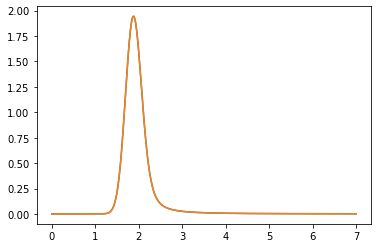

In [ ]:
x = np.linspace(0,7,1000)
sf = 10
params=l_params[8,:]
print(params)
y = [ params[1]*pylandau.get_langau_pdf(x_, params[0], params[1], params[2]) for x_ in x ]
y2 = [ sf*params[1]*sf*pylandau.get_langau_pdf(x_*sf, *(params*sf)) for x_ in x ]
plt.plot(x,y)
plt.plot(x,y2)

In [4]:
def langau_pdf(dedx, mpv, eta, sig):
    return eta * pylandau.get_langau_pdf(dedx, mpv, eta, sig)

In [66]:
import cer_util
cer = cer_util.CER()
cer.load_muons()
cer.slim_muons() 

Loading Data...
Loaded!
Sorting into array of muons...
Done!
Removed 5661 muons.


The likelihood will only depend on the dedxs and the landau fit parameters. The true energies are calculated for reference. For a given dedx ($x_i$) the probability that it corresponds to a measurement from energy bin $j$ is given by:
$$p_j(x_i)=\frac{f(x_i;\vec{\theta}_j)}{\sum_{k}f(x_i;\vec{\theta}_k)}$$
where $f$ is the langau pdf and the denominator is the sum of the langau pdfs at $x_i$ over all energy bins. **Assuming the $x_i$ are independent (which is wrong)**, the likelihood that all the data $x_i$ correspond to energy bin with parameters $\vec{\theta}_j$ is:
$$\mathscr{L}(\vec{\theta}_j)=\prod_i\frac{f(x_i;\vec{\theta}_j)}{\sum_k f(x_i; \vec{\theta}_k)}$$
We use the log-likelihood:
$$\log\mathscr{L}(\vec{\theta}_j)=\sum_i\left[\log f(x_i;\vec{\theta}_j)-\log \sum_k f(x_i; \vec{\theta}_k)\right]$$
This uses an incorrect assumption that the $x_i$ are all independent. In principle, the $x_i$ should follow the Bethe-Bloch curve as each subsequent $x_i$ corresponds to an energy loss from a muon of slightly lower kinetic energy. Corrections for this effect will be implemented later. Then the matter of maximizing the likelihood is akin to selecting energy bin $j$ with the highest $\mathscr{L}$.

In [67]:
def like_max(dedxs):
    landau_params = np.array([ fitdata.iloc[i][:3] for i in range(fitdata.shape[0]) ])
    
    # One big list comprehension for maximum calculation speed
    loglike = np.array([ np.sum([ np.log(langau_pdf(xi, *fj_params)) - np.log(np.sum([ langau_pdf(xi, *fk_params) for fk_params in landau_params])) for xi in dedxs ]) for fj_params in landau_params])
    
    jtilde = np.argmax(loglike)
    e_min_tilde, e_max_tilde = fitdata.iloc[jtilde,-2:]
    return e_min_tilde, e_max_tilde, loglike

In [68]:
def reconstruct_e(muon):  
    es, dedxs = cer.generate_eloss(muon)
    e_min_tilde, e_max_tilde, loglike = like_max(dedxs)
    return e_min_tilde, e_max_tilde, loglike

In [113]:
truth = []
reconstructed = []
loglikes = []
p_count = 0

tot_particles = len(muons)
pcnt_per_count = 100./tot_particles
count_per_pcnt = 1/pcnt_per_count
running_count_for_pcnt_increment = 0

print("Generating elosses and reconstructing energy...")
start = time.perf_counter()
for muon in cer.muons:
    if p_count > running_count_for_pcnt_increment:
        print(f"{(running_count_for_pcnt_increment / tot_particles)*100:.0f}%   ", end = '\r', flush=True)
        running_count_for_pcnt_increment += count_per_pcnt
        
    p_count += 1
    e_min, e_max, loglike = reconstruct_e(muon)
    
    true_e = muon['backtracked_e']
    truth.append(true_e)
    
    guess_e = (e_min, e_max)
    reconstructed.append(guess_e)
    loglikes.append(loglike)
    
end = time.perf_counter()
t = end-start
print(f"Done! Analysis time: {int(t//60)}m {t%60:0.1f}s")

Generating elosses and reconstructing energy...


KeyboardInterrupt: 

In [111]:
like_data_dict = []
for i in range(len(truth)):
    t = truth[i]
    re_min = reconstructed[i][0]
    re_max = reconstructed[i][1]
    
    this_dict = {'truth': t, 'reconstructed_min': re_min, 'reconstructed_max': re_max}
    
    for j in range(len(loglikes[i])):
        like = loglikes[i][j]
        this_dict[f'L{j}'] = like
    
    like_data_dict.append(this_dict)
    
like_data = pd.DataFrame.from_dict(like_data_dict)

In [112]:
like_data.to_csv(r'./data/stat_binned_likelihood_data.csv', index=False, header=True)

## Analytic Likelihood

I will attempt to construct an analytic likelihood function based on the theoretical MPV values found in `Fit.ipynb` as well as the assumption that the Langau spreads $\eta$ and $\sigma$ are independent of muon energy (which they are, for the most part, although I am not sure of the theoretical prediction). The only value that will end up depending on the energy of the incoming muon is the MPV, which will be the parameter we minimize over. We must assume some uniform $\sigma$ and $\eta$, and I will just select the quadrature means of the fixed-width langau fits from before. I am not certain that this choice is robust, however perhaps there is some theory to work with for these values later down the line.

$$\mathscr{L}_i=f\left(x_i; \frac{\Delta_p}{dx}(E, \Delta p_i), \eta(E, \Delta p_i), \sigma(E, \Delta p_i)\right)$$
where $\Delta p=\frac{0.3\,\text{cm}}{\cos(\gamma)}$ is the pitch, $E$ is the true energy, and $\frac{\Delta_p}{dx}, \eta, \sigma$ are the MPV, Landau FWHM, and Gaussian width of the Langau. We expect that the $E$ should also be subscripted $i$ as the true energy changes with each energy loss but for now we continue to approximate the true energy as constant:
$$-\ln(\mathscr{L}(E))=-\sum_i \ln\left(f\left[x_i; \frac{\Delta_p}{dx}(E, \Delta p_i), \eta(E, \Delta p_i), \sigma(E, \Delta p_i)\right]\right)$$
I imagine that this is highly computationally expensive --- there may be some trick to lower the computational difficulty by utilizing the Laplace Transform (since $f=L\{s^s\}$).

Load stand-in $\eta$, $\sigma$:

In [3]:
import pandas as pd
fit_data_loc = r'./data/stat_fixedwidth_fit_data_full.csv'
fitdf = pd.read_csv(fit_data_loc)
eta = fitdf.eta[0]
sig = fitdf.sigma[0]

In [5]:
from util.theory import *

def analnegloglike(e, dedxs, pitches=[], eta=eta, sig=sig):
    mpv = dpdx(e-Mmu, thickness , Mmu)